In [16]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform, LinearFilterBank
import matplotlib.pyplot as plt
from invertiblewavelets import *
from scipy import signal

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [44]:
data = np.load("data.npy")
data[2500] += 1000
# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array


#### Create Transform Object and Analysis Filters

In [45]:
"Pad Length"
fb = DyadicFilterBank(wavelet=Cauchy(1000) , fs=sample_rate, N=4*num_samples, real=False, s_max = 2, dj = 1/12)
#self, n: int = 1, scale: float = 1.0, N: int = 4096, dt: float = 1.0
transform = Transform(
    data=data,
    fs = sample_rate,
    filterbank=fb,
    pad_method='symmetric', # Padding method for the convolution calls np.pad. Set to None if no padding
)


Text(0.5, 0, 'Frequency Channel')

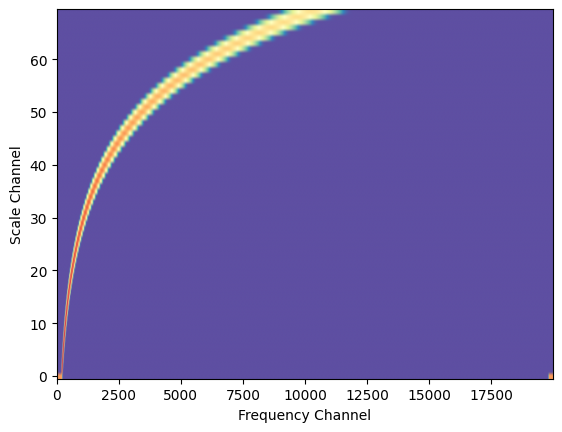

In [46]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r', interpolation=None)
ax.set_ylabel('Scale Channel')
ax.set_xlabel('Frequency Channel')

#### Transform and Inverse the Data

Reconstruction error: (0.030686464371184635+0.051996771104830225j)


c:\Users\aphoffm2\AppData\Local\anaconda3\envs\mag\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\aphoffm2\AppData\Local\anaconda3\envs\mag\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


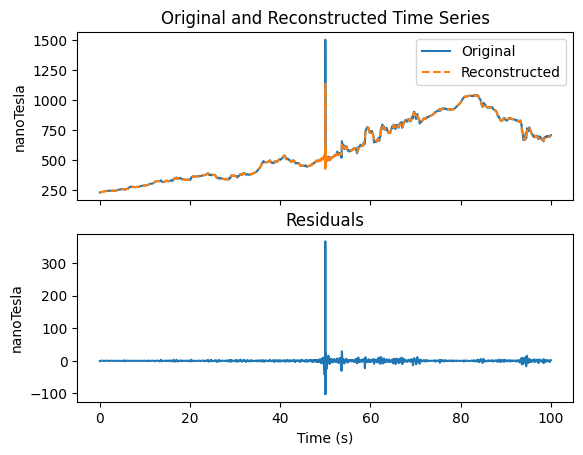

In [47]:
# Perform forward wavelet transform
coefficients = transform.forward(data, trim = False)

# Perform inverse wavelet transform (reconstruction)
reconstructed = transform.inverse()

# Calculate and print reconstruction error
reconstruction_error = np.sqrt(np.mean((reconstructed - data)**2))
print(f"Reconstruction error: {reconstruction_error}")

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(t, data, label='Original')
ax[0].plot(t, reconstructed, label='Reconstructed', linestyle='--')    
ax[0].set_ylabel('nanoTesla')
ax[0].legend()
ax[0].set_title('Original and Reconstructed Time Series')
ax[1].plot(t, data - reconstructed)
ax[1].set_title('Residuals')
ax[1].set_ylabel('nanoTesla')
ax[1].set_xlabel('Time (s)')
plt.show()

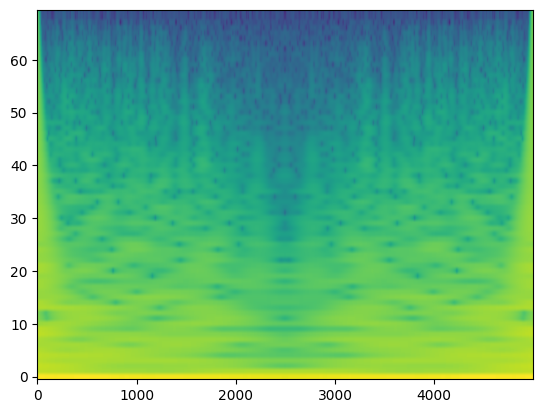

In [51]:
out = np.roll(coefficients, transform.N_orig//2)[:,transform.pad_width:transform.pad_width+transform.N_orig]
plt.imshow(np.log(np.abs(out)), aspect='auto', origin='lower')

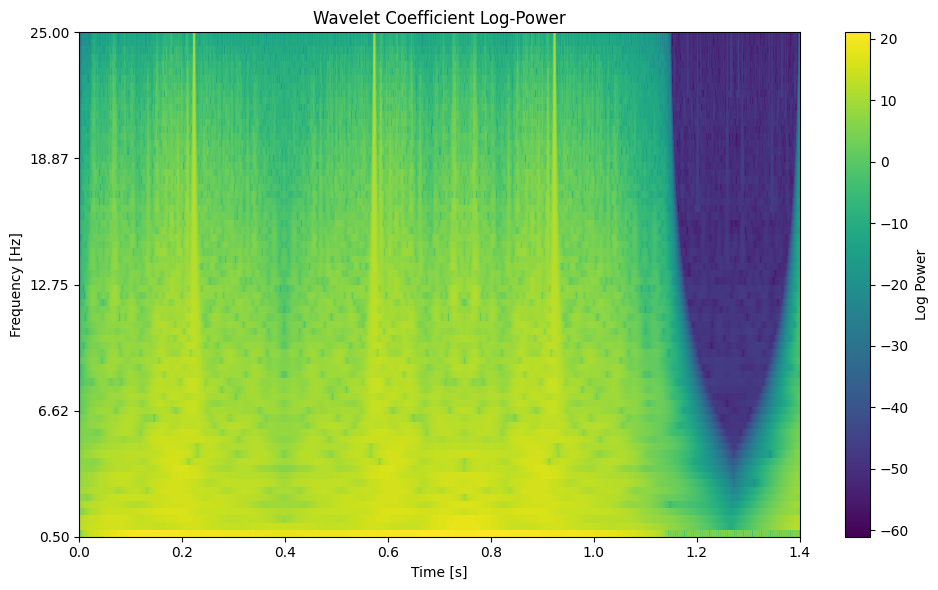

In [49]:
transform.scalogram(coefficients)

In [29]:
Lx = transform.N_padded        # 16384
Lh = transform.Wfreq.shape[1]  # 5000
N  = transform.N_orig          # 5000
pw = transform.pad_width       # 5692

# your raw long-path coeff matrix:
coeffs = coefficients          # shape (70, 21383)

# 1) undo the missing phase-delay: delay = (Lh-1)//2 = 2499
delay   = (Lh - 1)//2
rolled  = np.roll(coeffs, -delay, axis=1)

# 2) trim off exactly the pad_width on the left, and N_orig samples
start   = pw
stop    = pw + N
trimmed = rolled[:, start:stop]   # shape (70, 5000)

# now plot trimmed:
plt.imshow(
    np.log(np.abs(trimmed) + 1e-3),
    aspect='auto', origin='lower', interpolation='none'
)
plt.title("Long-path trimmed & delay-corrected")


Text(0.5, 1.0, 'Long-path trimmed & delay-corrected')

#### Check the wavelet spectral coverage

#### Check Wavelet Orthgonality

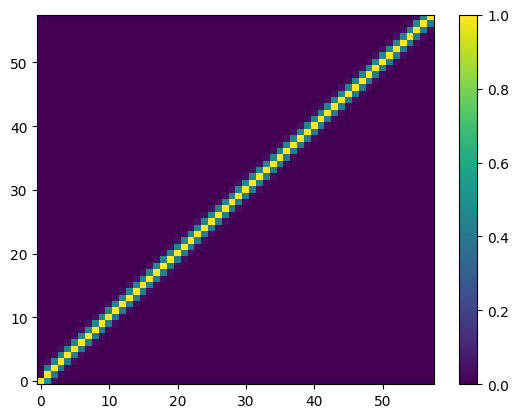

In [17]:
w_time = np.fft.ifft(transform.Wfreq, axis=-1)
delta_kl = w_time.conj() @ w_time.T
delta_kl = delta_kl / np.max(delta_kl, axis=1)[:, np.newaxis]
plt.imshow(np.abs(delta_kl), aspect='auto', origin='lower')
cbar = plt.colorbar()

#### Check Spectral Leakage

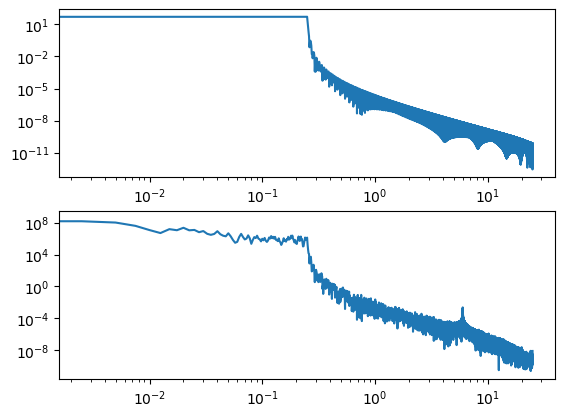

In [9]:
fig, ax = plt.subplots(2,1)
i = 0
N = coefficients.shape[-1]
freqs = np.fft.fftfreq(N, d=1/sample_rate)
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i][:N//2]))
ax[1].plot(freqs[:N//2], np.abs(np.fft.fft(coefficients, axis=1))[i][:N//2])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')